# Lab 1: Gaussian Process Regression

The aim of this lab, and this notebook, is to introduce the concepts from the lectures in a practical manner. We will cover key aspects of the Gaussian process regression: the covariance function, sampling a Gaussian process, and the regression model.

...

## 1. Getting started



In [1]:
# Support for maths
import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy

### Covariance functions, aka kernels

Example, the exponentiated quadratic, aka Gaussian, aka squared exponential, aka RBF

$$
    \kappa_\mathrm{rbf}(x,x') = \sigma^2\exp\left(-\frac{(x-x')^2}{2\mathscr{l}^2}\right)
$$

The parameters are described as the variance, $\sigma^2$ and the lengthscale $\mathscr{l}$.

In GPy, to create a kernel 

In [2]:
# Create a 1-D RBF kernel with default parameters
k = GPy.kern.RBF(1)
# Preview the kernel's parameters
k

rbf.,value,constraints,priors
variance,1.0,+ve,
lengthscale,1.0,+ve,


### Visualising the kernel


Note, one can obtain the left-hand plot by simply calling ```k.plot_covariance()```

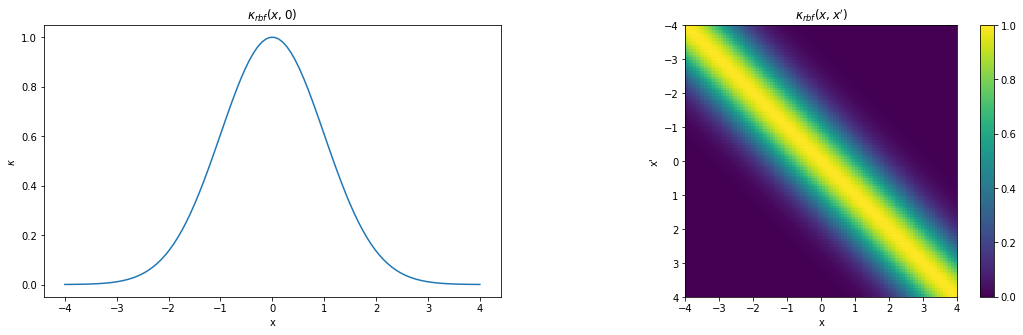

In [3]:
# Our sample space
X = np.linspace(-4.,4.,100)[:, None]

# Set up the plotting environment
plt.figure(figsize=(18,5))

# First, plot the kernel at x' = 0
plt.subplot(121)

C = k.K(X, np.array([[0.]]))
plt.plot(X,C)
plt.xlabel("x"), plt.ylabel("$\kappa$")
plt.title("$\kappa_{rbf}(x,0)$")

# Plot the covariance of the sample space

plt.subplot(122)

# Note: the kernel takes two inputs, and outputs the covariance between each respective point in the two inputs
C = k.K(X,X)

plt.pcolor(X.T,X,C)

plt.gca().invert_yaxis(), plt.gca().axis("image")
plt.xlabel("x"), plt.ylabel("x'"), plt.colorbar()
plt.title("$\kappa_{rbf}(x,x')$");

## Setting the kernel parameters

The parameters of the kernel ...

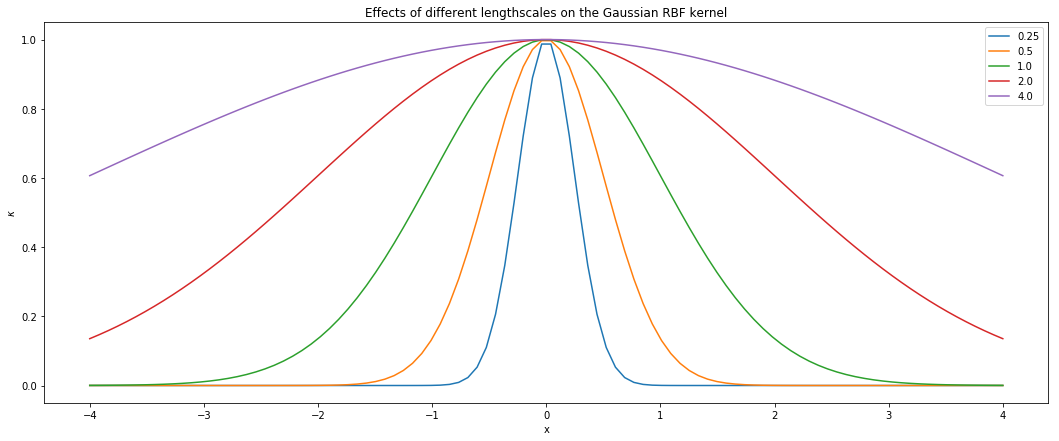

In [4]:
k = GPy.kern.RBF(1)
ls = [0.25, 0.5, 1., 2., 4.]

plt.figure(figsize=(18, 7))
for l in ls:
    k.lengthscale = l
    #k.plot_covariance()
    C = k.K(X, np.array([[0.]]))
    plt.plot(X,C)
    
plt.xlabel("x"), plt.ylabel("$\kappa$") 
plt.title("Effects of different lengthscales on the Gaussian RBF kernel")
plt.legend(labels=ls);

### Exercise 1

(a) What is the effect of the lengthscale parameter on the covariance function?

```[answer]```
> _It causes the covariances to be higher between more distant locations in the input domain, i.e. nearby samples from the corresponding Gaussian process will be more likely to be similar as the lengthscale increased._

(b) Change the code used above to plot the covariance function showing the effects of the variance on the length scale. Comment on the effect.

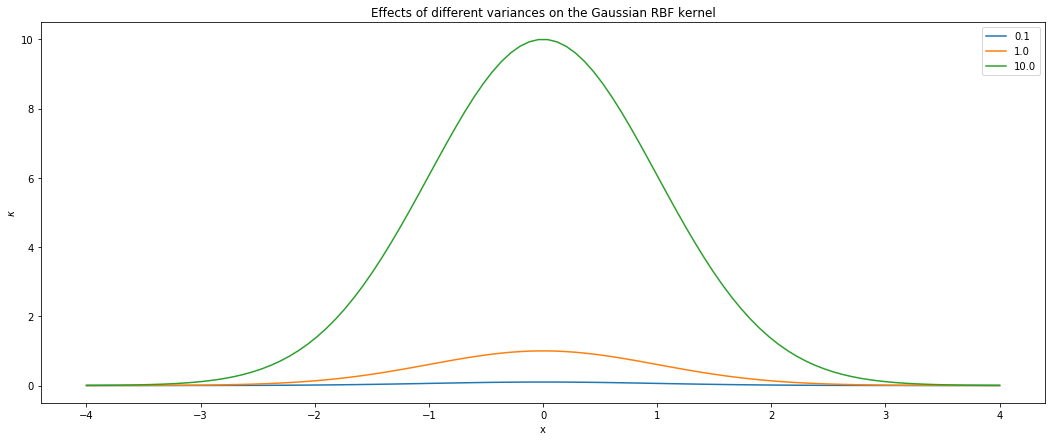

In [5]:
# [answer]

k = GPy.kern.RBF(1)
vs = [0.1, 1., 10.]

plt.figure(figsize=(18, 7))
for v in vs:
    k.variance = v
    #k.plot_covariance()
    C = k.K(X, np.array([[0.]]))
    plt.plot(X,C)
    
plt.xlabel("x"), plt.ylabel("$\kappa$") 
plt.title("Effects of different variances on the Gaussian RBF kernel")
plt.legend(labels=vs);

```[answer]```
> _Increasing the variance parameter increases the covariance proportionally between all points, allowing for modelling of data with different variance._

---

## 2. Types of covariance function

There are many different covariance functions already implemented in GPy. Aside from the `RBF` kernel, there includes

- `Exponential`
- `Matern32`
- `Matern52`
- `Brownian`
- `Bias`
- `Linear`
- `StdPeriodic`
- `Cosine`
- `PeriodicMatern32`

Note: when defining these, all are preceded by `GPy.kern.`

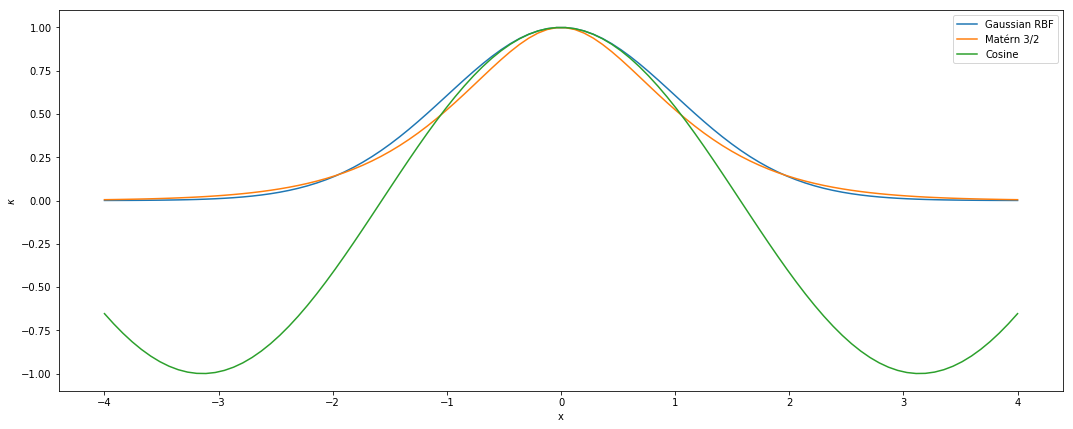

In [6]:
k_R = GPy.kern.RBF(1)
C_R = k_R.K(X, np.array([[0.]]))

k_M = GPy.kern.Matern52(1)
C_M = k_M.K(X, np.array([[0.]]))

k_C = GPy.kern.Cosine(1)
C_C = k_C.K(X, np.array([[0.]]))

plt.figure(figsize=(18,7))
plt.plot(X, C_R, X, C_M, X, C_C);
plt.xlabel("x"), plt.ylabel("$\kappa$") 
plt.legend(labels=["Gaussian RBF", "Matérn 3/2", "Cosine"]);

Some kernels are not parameterised by a lengthscale. For example, the `Linear` kernel has only a list of variances corresponding to each linear component

In [7]:
GPy.kern.Linear(1)

linear.,value,constraints,priors
variances,1.0,+ve,


Likewise, not every kernel is stationary. In the case of the Gaussian RBF, or Matérn kernels, the kernel can be written $\kappa(x,x') = f(x-x')$, however this is not true for, e.g., the Brownian covariance function:

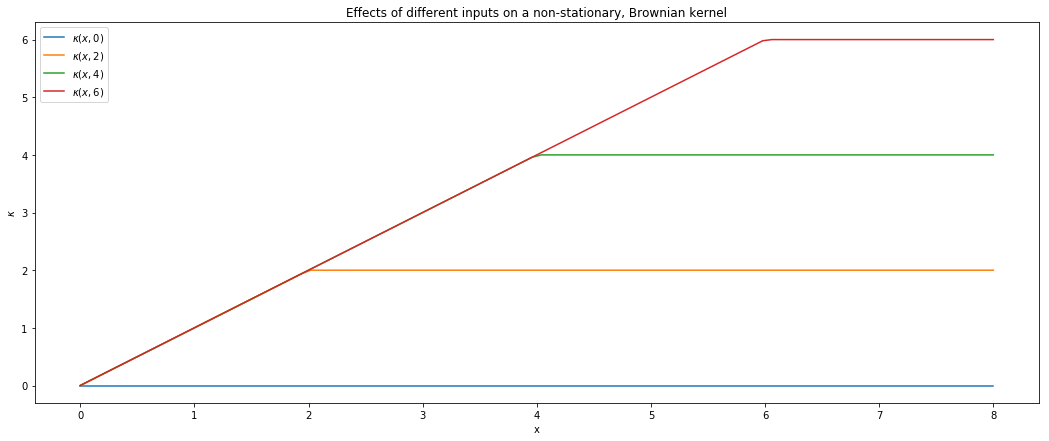

In [8]:
k_B = GPy.kern.Brownian(1)

X = np.linspace(0., 8., 100)[:,None] # only positive X

plt.figure(figsize=(18,7))
for x_ in np.array([0., 2., 4., 6.]):
    C_B = k_B.K(X, np.array([[x_]]))
    plt.plot(X, C_B)
    
plt.xlabel("x"), plt.ylabel("$\kappa$")
plt.title("Effects of different inputs on a non-stationary, Brownian kernel")
plt.legend(labels=["$\kappa(x,0)$", "$\kappa(x,2)$", "$\kappa(x,4)$", "$\kappa(x,6)$"]);

### Compute the covariance function given the input data, $\mathbf{X}$

???

---

## 3. Combining covariance functions

### Exercise 2

(a) A matrix, $\mathbf{K}$, is positive semi-definite if the matrix inner product is greater than or equal to zero, $\mathbf{x}^\text{T}\mathbf{K}\mathbf{x} \geq 0$, _regardless of the values in $\mathbf{x}$_. Given this, it should be easy to see that the sum of two positive semi-definite matrices is also positive sem-definite. In the context of Gaussian processes, this is the sum of two covariance functions. What does this mean from a modelling perspective?

(b) What about the element-wise product of two covariance functions? If we define $k(\mathbf{x}, \mathbf{x}') = k_1(\mathbf{x},\mathbf{x}')k_2(\mathbf{x},\mathbf{x}')$, then is $k(\mathbf{x},\mathbf{x}')$ a valid covariance function?

### Combining kernels in GPy

#### Summing kernels

In [9]:
k_R = GPy.kern.RBF(1, lengthscale=2.)
k_M = GPy.kern.Matern52(1, variance=2., lengthscale=4.)

k_sum = k_R + k_M
k_sum

sum.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,2.0,+ve,
Mat52.variance,2.0,+ve,
Mat52.lengthscale,4.0,+ve,


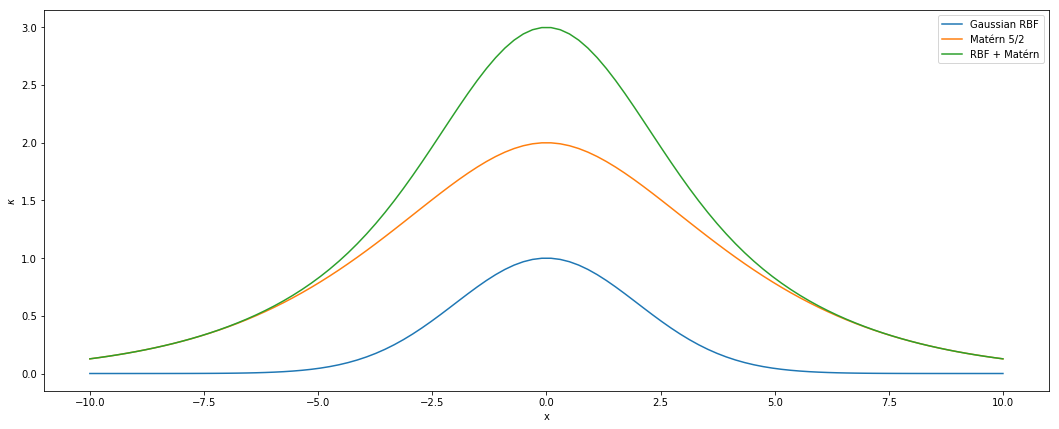

In [10]:
X = np.linspace(-10., 10., 100)[:,None]

plt.figure(figsize=(18,7))

C_R   = k_R.K(X, np.array([[0.]]))
C_M   = k_M.K(X, np.array([[0.]]))
C_sum = k_sum.K(X, np.array([[0.]]))

plt.plot(X, C_R, X, C_M, X, C_sum)
    
plt.xlabel("x"), plt.ylabel("$\kappa$")
plt.legend(labels=["Gaussian RBF", "Matérn 5/2", "RBF + Matérn"]);

#### Multiplying two kernels

In [11]:
k_R = GPy.kern.RBF(1, lengthscale=5.)
C_R = k_R.K(X, np.array([[0.]]))

k_P = GPy.kern.StdPeriodic(1, period=5.)
C_P = k_P.K(X, np.array([[0.]]))

k_mul = k_R * k_P
k_mul

mul.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,5.0,+ve,
std_periodic.variance,1.0,+ve,
std_periodic.period,5.0,+ve,
std_periodic.lengthscale,1.0,+ve,


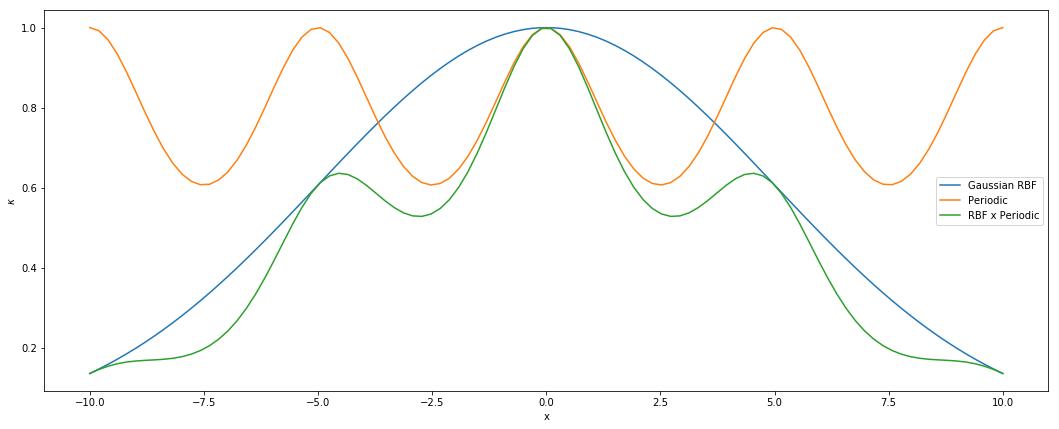

In [12]:
plt.figure(figsize=(18,7))

C_R   = k_R.K(X, np.array([[0.]]))
C_P   = k_P.K(X, np.array([[0.]]))
C_mul = k_mul.K(X, np.array([[0.]]))

plt.plot(X, C_R, X, C_P, X, C_mul)
    
plt.xlabel("x"), plt.ylabel("$\kappa$")
plt.legend(labels=["Gaussian RBF", "Periodic", "RBF x Periodic"]);

---

## 4. Sampling from a Gaussian Process

The following plots demonstrate samples from a Gaussian process prior and the corresponding covariance matrix


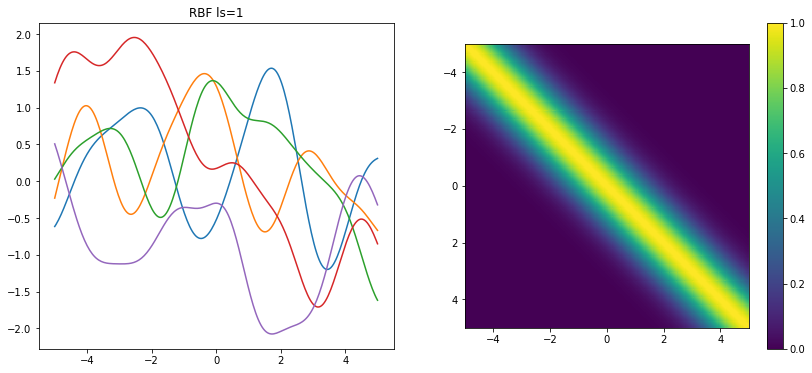

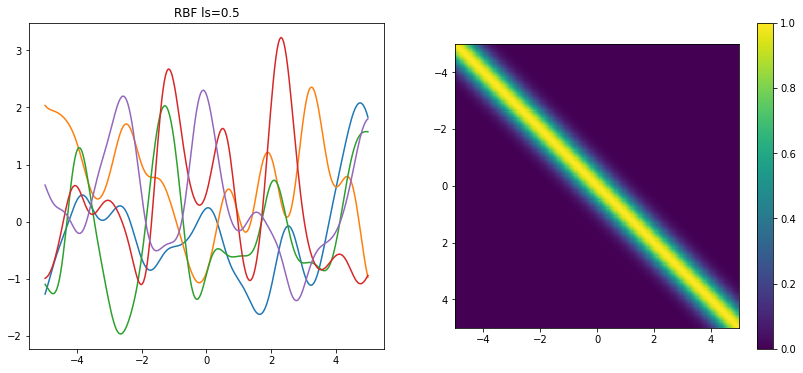

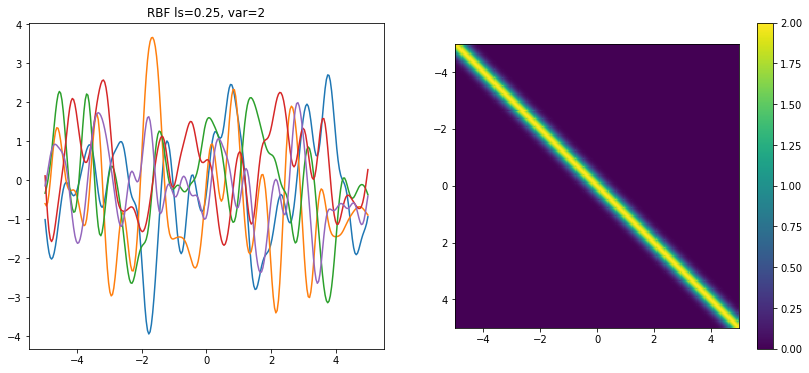

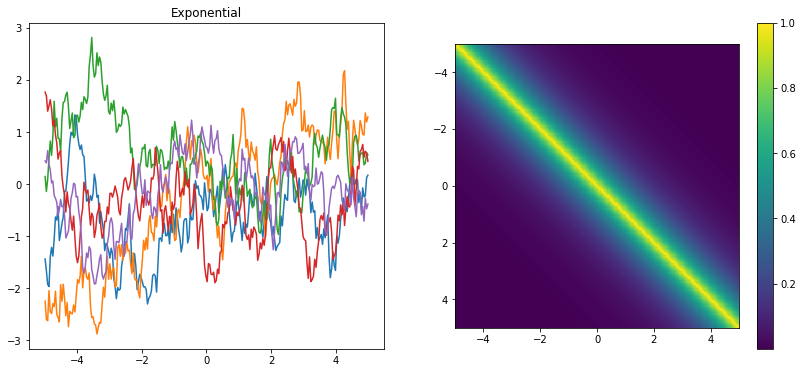

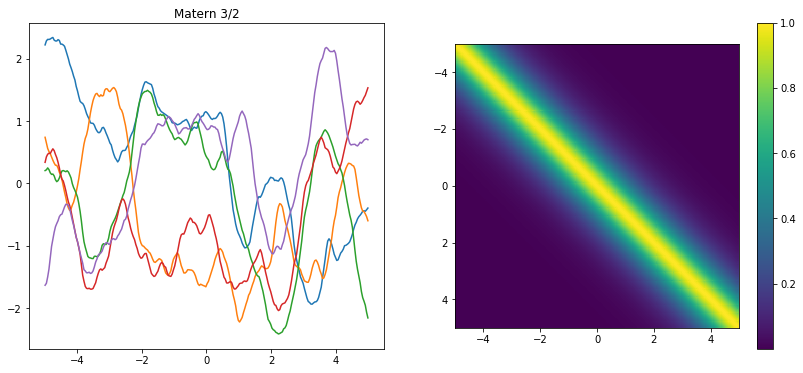

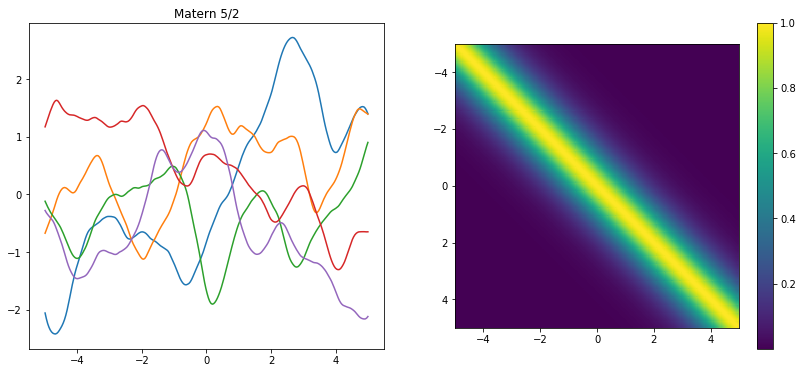

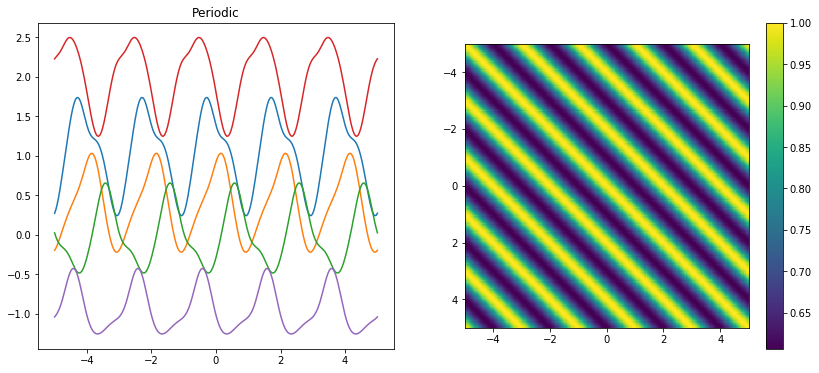

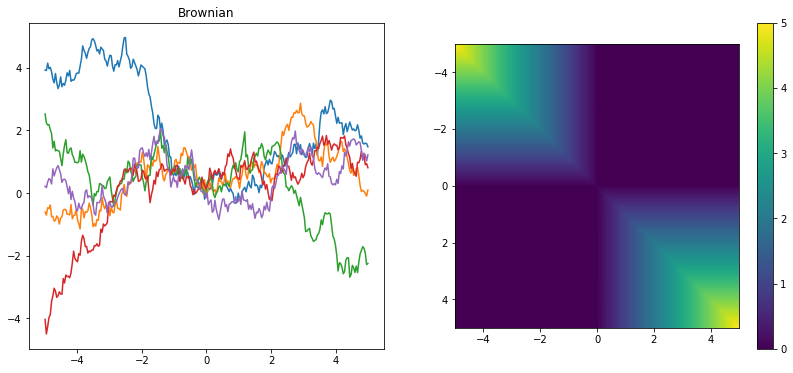

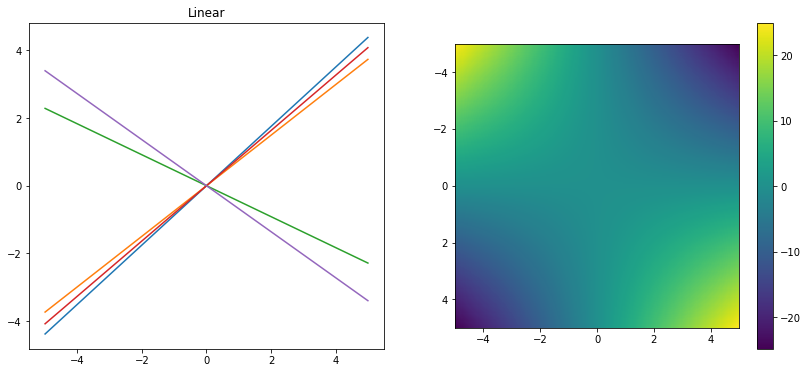

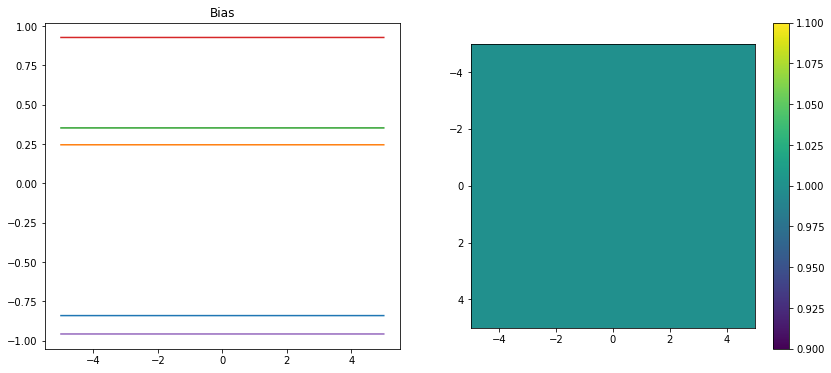

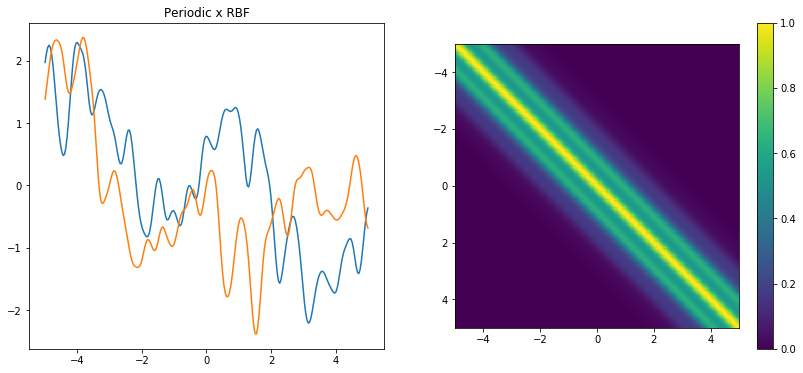

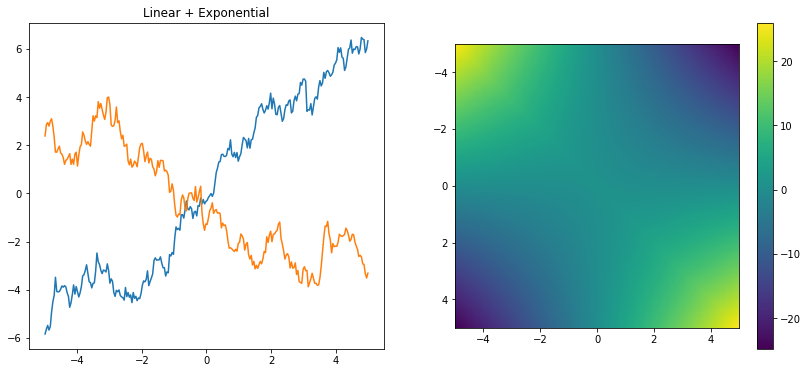

In [13]:
ks = [ # List of example kernels
    GPy.kern.RBF(1, lengthscale=1.),
    GPy.kern.RBF(1, lengthscale=0.5),
    GPy.kern.RBF(1, lengthscale=0.25, variance=2.),
    GPy.kern.Exponential(1),
    GPy.kern.Matern32(1),
    GPy.kern.Matern52(1),
    GPy.kern.StdPeriodic(1, period=2.),
    GPy.kern.Brownian(1),
    GPy.kern.Linear(1),
    GPy.kern.Bias(1),
    GPy.kern.StdPeriodic(1)*GPy.kern.RBF(1),
    GPy.kern.Linear(1) + GPy.kern.Exponential(1)
]
kernel_name = ["RBF ls=1", "RBF ls=0.5", "RBF ls=0.25, var=2", "Exponential", "Matern 3/2", 
               "Matern 5/2", "Periodic", "Brownian", "Linear", "Bias", "Periodic x RBF", "Linear + Exponential"]

X = np.linspace(-5., 5., 250)[:, None]

print("The following plots demonstrate samples from a Gaussian process prior and the corresponding covariance matrix")

for i,k in enumerate(ks):
    # The mean function is set to 0
    mu = np.zeros((250))
    # Get the covariance matrix
    C  = k.K(X,X)
    # Sample 5 times from a multivariate Gaussian distribution with mean 0 and covariance k(X,X)
    Z  = np.random.multivariate_normal(mu, C, 5)
    
    # Plotting
    plt.figure(figsize=(14, 6))
    # Show samples on left hand side
    plt.subplot(121)
    for j in range(5 if i < 10 else 2):
        plt.plot(X[:],Z[j,:])
        plt.title(kernel_name[i])
    # Visualise covariance matrix on right hand side
    plt.subplot(122)
    plt.pcolor(X.T, X, C)
    plt.gca().invert_yaxis(), plt.gca().axis("image")
    plt.colorbar()


These samples are from the Gaussian process prior made up of the covariance function and a zero mean. After GP regression, the fitted posterior can also be sampled in this manner, to get samples of the fitted function.

### Exercise 3

Can you identify the covariance function used to generate the following samples?

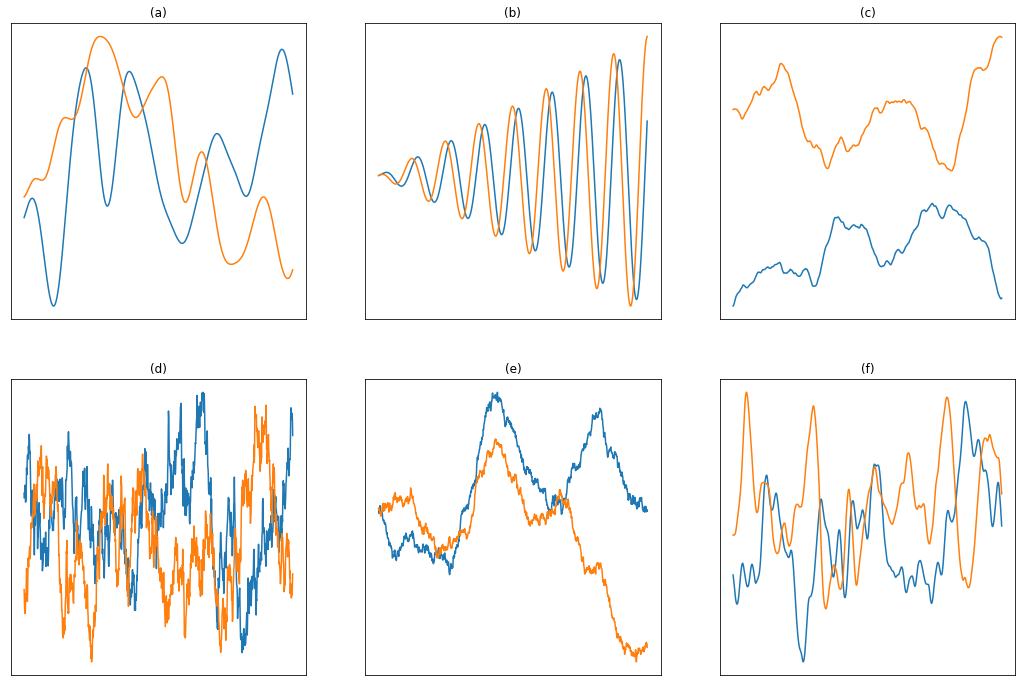

In [14]:
### THIS CODE WILL BE HIDDEN, WILL COPY THE RESULTING FIGURE

f, axs = plt.subplots(2,3,figsize=(18,12))
X = np.linspace(0., 5., 1000)[:, None]
ks = [
    GPy.kern.RBF(1, lengthscale=0.25),
    GPy.kern.Cosine(1, lengthscale=0.1) * GPy.kern.Linear(1),
    GPy.kern.Bias(1) + GPy.kern.Matern32(1, lengthscale=0.5, variance=1),
    GPy.kern.Exponential(1, lengthscale=0.3),
    GPy.kern.RBF(1, lengthscale=0.5) * GPy.kern.Brownian(1),
    GPy.kern.Matern52(1, lengthscale=0.15) * GPy.kern.StdPeriodic(1)
]

labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"]

for i in range(2):
    for j in range(3):
        k = ks[i*3+j]
        Z = np.random.multivariate_normal(np.zeros((1000)), k.K(X, X), 2)
        for z in Z:
            axs[i,j].plot(X, z)
            axs[i,j].set_title(labels[ i*3+j])
            axs[i,j].tick_params(
                axis="both",
                which="both",
                bottom=False,
                left=False,
                labelleft=False,
                labelbottom=False
            )
            axs[i,j].axis("tight")

(a)

(b)

(c)

(d)

(e)

(f)

```[answers]```
> _(a) Gaussian / RBF_
>
> _(b) Linear * Cosine_
>
> _(c) Matern 3/2 + Bias_
>
> _(d) Exponential (low lengthscale)_
>
> _(e) Brownian * RBF_
>
> _(f) Periodic * Matern 5/2_


---

## 5. Gaussian Process Regression

Suppose we have a data model for which we only have noisy observations, $y = f(x) + \epsilon$ at some small number of sample locations, $\mathbf{X}$. Here, we set up an example function

$$
    f(x) = -\cos(2\pi x) + \frac{1}{2}\sin(6\pi x)
$$
$$
    \mathbf{y} = f(\mathbf{X}) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.01)
$$


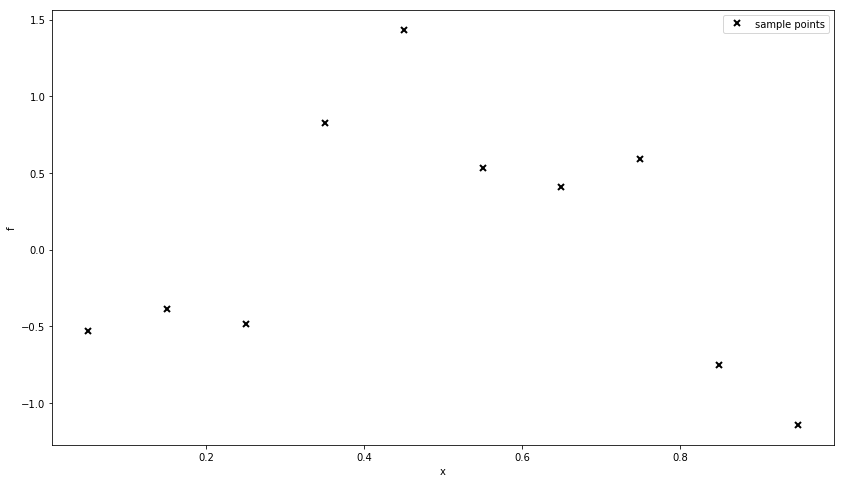

In [15]:
f = lambda x: -np.cos(2*np.pi*x) + 0.5*np.sin(6*np.pi*x) # lambda function, call f(x) to generate data

# 10 equally spaced sample locations 
X = np.linspace(0.05, 0.95, 10)[:,None]

# y = f(X) + epsilon
Y = f(X) + np.random.normal(0., 0.1, (10,1)) # noise is normally distributed with mean=0, variance=0.01

plt.figure(figsize=(14, 8))

# Plot observations
plt.plot(X, Y, "kx", mew=2)

plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["sample points"]);

A Gaussian process regression model using a Gaussian RBF covariance function can be defined first by setting up the kernel:

In [16]:
k = GPy.kern.RBF(1, variance=1., lengthscale=0.1, name="rbf")

And then combining it with the data to form a Gaussian process regression model, with $\mathbf{X}^*$ representing _any_ new inputs (imagine $\mathbf{f}^*$ approximates $f(\mathbf{X}^*)$):

$$
\left.\mathbf{f}^*\,\right|\,\mathbf{X}^*,\mathbf{X},\mathbf{y} \sim \mathcal{N}\left(\mathbf{m}, \mathbf{C}\right)
$$

Where $
\mathbf{m} = \mathbf{K}_{*x}(\mathbf{K}_{xx} + \sigma^2\mathbf{I})^{-1}\mathbf{y}$ and $\mathbf{C} = \mathbf{K}_{**} -  \mathbf{K}_{*x}(\mathbf{K}_{xx} + \sigma^2\mathbf{I})^{-1}\mathbf{K}_{x*}^\text{T}
$

and covariance matrices are defined by evaluations of the kernel functions: $\mathbf{K}_{xx} = k(\mathbf{X}, \mathbf{X})$; $\mathbf{K}_{*x} = k(\mathbf{X}^*, \mathbf{X})$; and $\mathbf{K}_{**} = k(\mathbf{X}^*,\mathbf{X}^*)$

In [17]:
# New test points to sample function from
Xnew = np.linspace(-0.05, 1.05, 100)[:, None]

# Covariance between training sample points (+ Gaussian noise)
Kxx = k.K(X,X) + 1 * np.eye(10)

# Covariance between training and test points
Kxs = k.K(Xnew, X)

# Covariance between test points
Kss = k.K(Xnew,Xnew)

# The mean of the GP fit
mean = Kxs @ np.linalg.inv(Kxx) @ Y
# The covariance matrix of the GP fit
Cov = Kss - Kxs @ np.linalg.inv(Kxx) @ Kxs.T

Here we define a quick plotting utility function for our GP fits. There are a number of plotting options available in GPy, but we will use the below method, which plots the mean and 95% confidence fit of a GP for a given input $\mathbf{X}^*$. Optionally, we will allow it to plot the initial training points.

In [18]:
def plot_gp(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    # Plot 95% confidence interval 
    plt.fill_between(X[:,0],
                     m[:,0] - 1.96*np.sqrt(np.diag(C)),
                     m[:,0] + 1.96*np.sqrt(np.diag(C)),
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X, m, "-")
    plt.legend(labels=["GP fit"])
    
    plt.xlabel("x"), plt.ylabel("f")
    
    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2)
        plt.legend(labels=["GP fit", "sample points"])

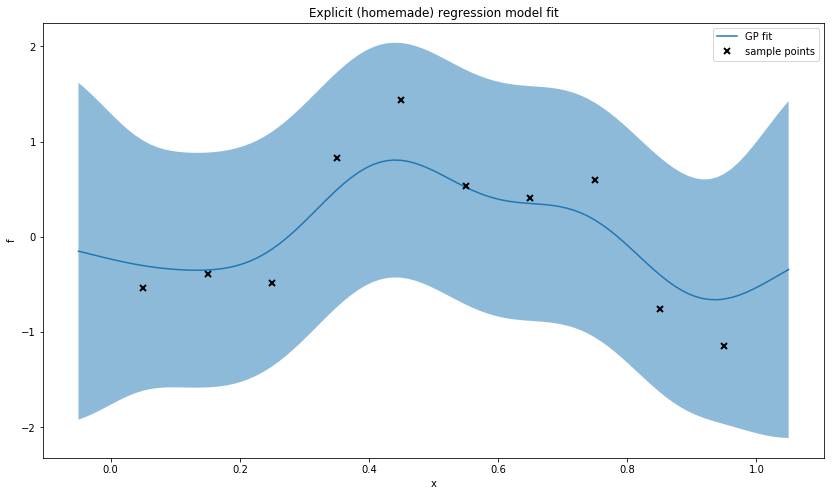

In [19]:
plt.figure(figsize=(14, 8))

# Plot the GP fit mean and covariance
plot_gp(Xnew, mean, Cov, training_points=(X,Y))
plt.title("Explicit (homemade) regression model fit");

We can also do this using GPy, by creating a GP regression model with sample points $(\mathbf{X}, \mathbf{Y})$ and the Gaussian RBF kernel:

In [20]:
m = GPy.models.GPRegression(X, Y, k)
m 

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,0.1,+ve,
Gaussian_noise.variance,1.0,+ve,


We can use GPy's regression and prediction tools, which _should_ give the same result as our basic implementation:

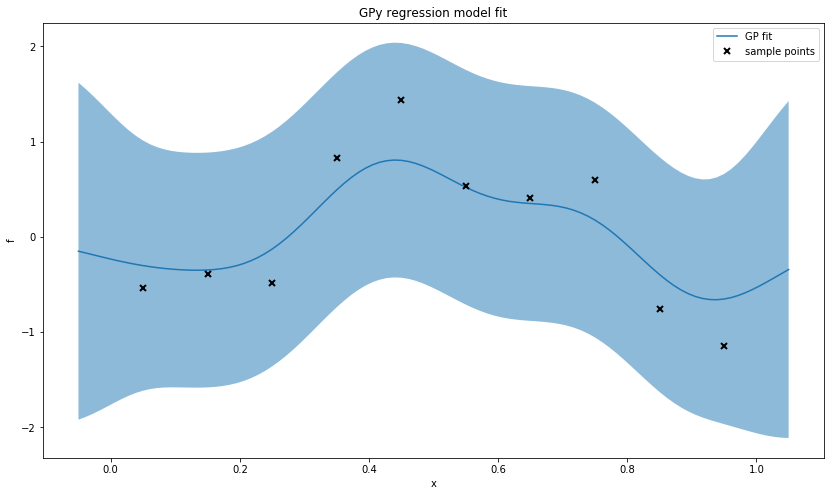

In [21]:
# Use GPy model to calculate the mean and covariance of the fit at Xnew
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)

plt.figure(figsize=(14, 8))

# Plot the GP fit mean and covariance
plot_gp(Xnew, mean, Cov, training_points=(X,Y))
plt.title("GPy regression model fit");

It can be clearly seen that this *is* the same fit as our above model. However, using GPy gives flexibility and ease of use for extending the capabilities of the fitting, including use of different kernels, optimising parameters and solving more complicated problems, including classification. We also don't need to write explicit equations and manually creating covariances matrices.

### Exercise 4

(a) What do you think of this initial fit? Does the prior given by the GP seem to be adapted?

(b) The parameters of the model can be editted much like those of the kernel. For example, 
```
m.Gaussian_noise = 0.1
```
or
```
m.rbf.variance = 2.0
```
Change the values of the parameters to try and obtain a better fit of the GP. You can recalculate the updated mean and covariance after changing the values by calling `m.predict_noiseless` as above.

*Note: changing the original kernel `k` will also affect the model parameters due to how Python connects objects, but this is not a reliable way of setting the parameters, so you should adjust the kernel parameters via the model `m` as described*

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,0.1,+ve,
Gaussian_noise.variance,0.01,+ve,


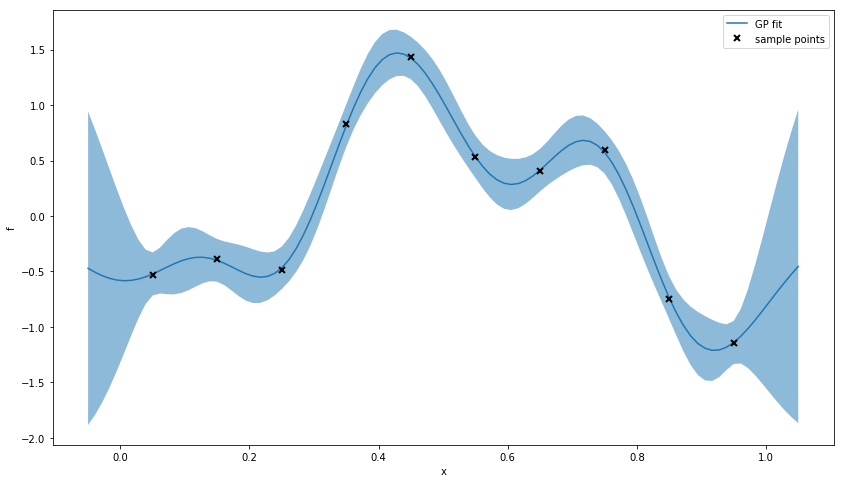

In [22]:
# [answer]
m.Gaussian_noise = 0.01
m.rbf.lengthscale = 0.1

mean, Cov = m.predict_noiseless(Xnew, full_cov=True)

plt.figure(figsize=(14, 8))
# Plot the GP fit mean and covariance
plot_gp(Xnew, mean, Cov, training_points=(X,Y))

m

(c) Given that we can obtain the mean and covariance of the GP fit, we can also sample the GP posterior as a multivariate Gaussian process. This can be done as in Section 4, where we sampled the priors as defined by the kernels, i.e. with `np.random.multivariate_normal`. Obtain 10 samples from the GP posterior and plot them alongside the data. Try to simulate noisy measurements using `m.predict` (rather than `m.predict_noiseless`).

*Remember to get the full covariance matrix, using `full_cov=True`, and note that to make the mean vector 1-D (for sampling a multivariate normal), you need `np.random.multivariate_normal(mean[:,0], Cov)`)*

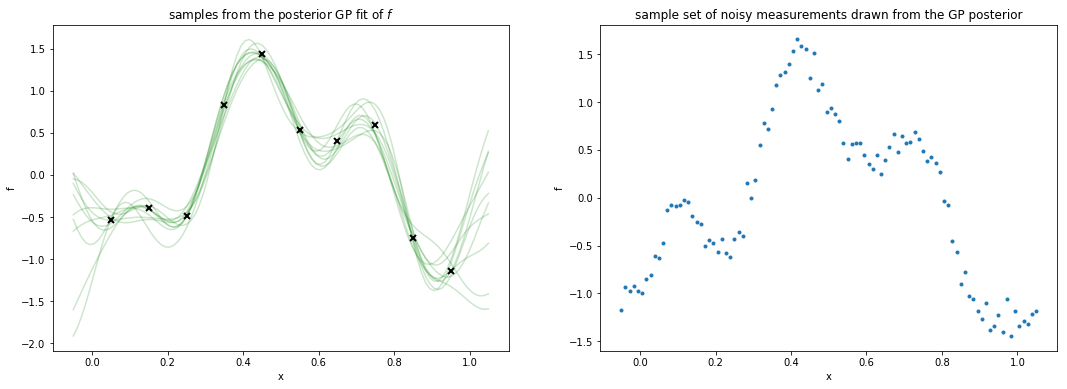

In [23]:
#[answer]
plt.figure(figsize=(18, 6))

mean, Cov = m.predict_noiseless(Xnew, full_cov=True)

Z  = np.random.multivariate_normal(mean[:,0], Cov, 10)
plt.subplot(121)
for z in Z:
    plt.plot(Xnew, z, "g-", alpha=0.2)
plt.plot(X, Y, "kx", mew=2)
plt.xlabel("x"), plt.ylabel("f"), plt.title("samples from the posterior GP fit of $f$")    

mean, Cov = m.predict(Xnew, full_cov=True)
z  = np.random.multivariate_normal(mean[:,0], Cov)
plt.subplot(122)
plt.plot(Xnew, z, ".")
plt.xlabel("x"), plt.ylabel("f"), plt.title("sample set of noisy measurements drawn from the GP posterior");

---

## 6. Covariance Function Parameter Estimation

In [24]:
m.optimize()
m

GP_regression.,value,constraints,priors
rbf.variance,0.6677852255113862,+ve,
rbf.lengthscale,0.10291813084698155,+ve,
Gaussian_noise.variance,1.9198805806694806e-09,+ve,


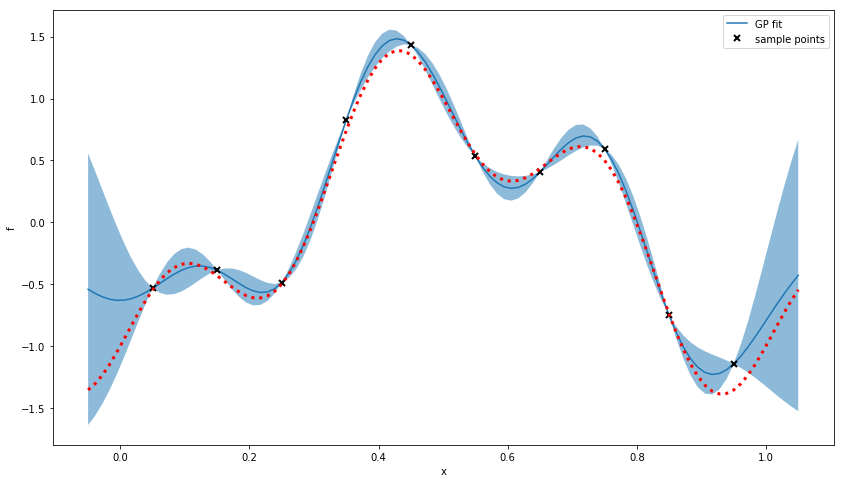

In [25]:
# Get mean and covariance of optimised GP
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)

plt.figure(figsize=(14, 8))

# Plot the GP fit mean and covariance
plot_gp(Xnew, mean, Cov, training_points=(X,Y))
plt.plot(Xnew, f(Xnew), "r:", lw=3)

### Parameter constraints

We can limit the values that the parameters take by adding constraints. For example, the variance and lengthscale can only be positive, so calling `constrain_positive`, we can enforce this (note that this is the default constraint for GP regression anyway).

In addition, if we *know*, or can reasonably approximate, the variance of the observation noise $\epsilon$, we can fix this parameter for the optimiser, using `fix`

In [26]:
# Constrain the regression parameters to be positive only
m.constrain_positive()

# Fix the Gaussian noise variance at 0.01 
m.Gaussian_noise.variance = 0.01 # (Reset the parameter first)
m.Gaussian_noise.variance.fix()

# Reoptimise
m.optimize()
m

reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.6531896994002909,+ve,
rbf.lengthscale,0.10369380610051246,+ve,
Gaussian_noise.variance,0.01,fixed +ve,


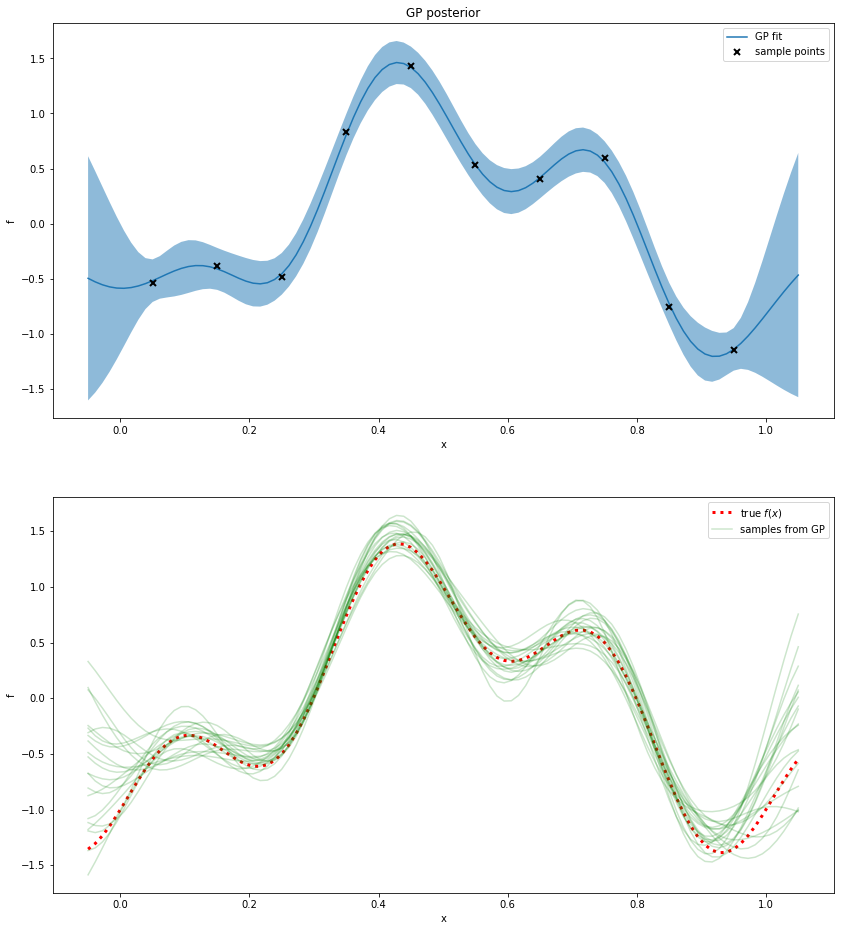

In [27]:
# Get mean and covariance of optimised GP
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)

plt.figure(figsize=(14, 16))


#
plt.subplot(211)
# Plot the GP fit mean and covariance
plot_gp(Xnew, mean, Cov, training_points=(X,Y))
plt.title("GP posterior")
plt.subplot(212)

plt.plot(Xnew, f(Xnew),"r:", lw=3)

Z  = np.random.multivariate_normal(mean[:,0], Cov, 20)
for z in Z:
    plt.plot(Xnew,z, "g-", alpha=0.2)
    
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["true $f(x)$", "samples from GP"]);

Using the prior knowledge of the noise in the data has given us a reasonably good approximation of the true function. The samples from the GP demonstrate provide fits to the observed data and roughly follow the shape of the true function $f$, particularly in the range for which we have samples.

### Exercise 5

The function we used is a sum of sinusoids, and therefore has inherent periodicity. However, we only have samples for a single period, so this is not directly seen in the domain of $[0, 1]$.

(a) Try predicting the function on the range of $[0, 2]$ instead (`Xnew = np.linspace(0., 2., 100)[:,None]`), and compare the fitted GP posterior with the true function $f$.

*Note, you shouldn't need to retrain the model or adjust the hyperparameters.*

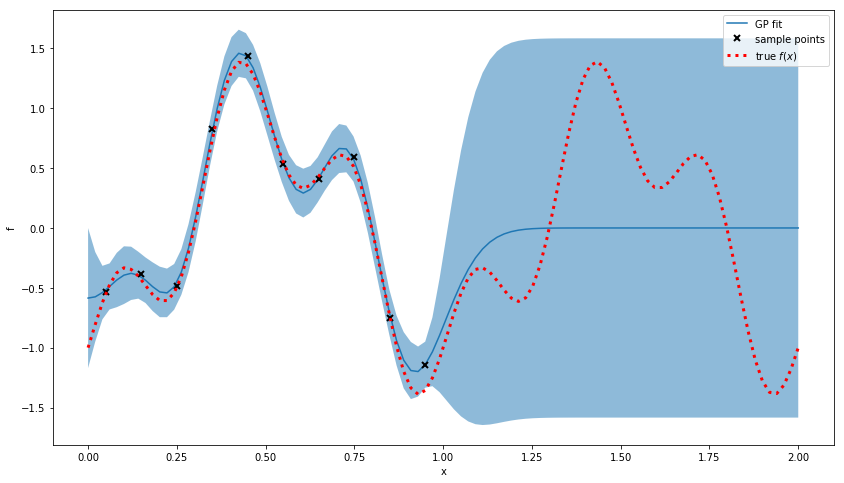

In [28]:
# [Answer]
Xnew = np.linspace(0., 2., 100)[:, None]
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)

plt.figure(figsize=(14, 8))
plot_gp(Xnew, mean, Cov, training_points=(X,Y))
plt.plot(Xnew, f(Xnew), "r:", lw=3)
plt.legend(labels=["GP fit", "sample points", "true $f(x)$"])

(b) Comment on the fit of the GP, and the uncertainty in regions where we have no observations. Is the GP still a good fit? How might we produce a better fit, for example, if we knew $f(x)$ had a periodic nature?

---

## 7. Real World Example



In [29]:
GPy.util.datasets.authorize_download = lambda x: True # This gives GPy permission to download the dataset
data = GPy.util.datasets.mauna_loa(refresh_data=False)

print("\nData keys:")
print(data.keys())

print("\nCitation:")
print(data['citation'])

print("\nInfo:")
print(data['info'])

Using cached version of the data set, to use latest version set refresh_data to True
Most recent data observation from month  6.0  in year  2018.0

Data keys:
dict_keys(['X', 'Y', 'Xtest', 'Ytest', 'info', 'citation', 'details', 'files', 'license', 'size', 'urls'])

Citation:
Mauna Loa Data. Dr. Pieter Tans, NOAA/ESRL (www.esrl.noaa.gov/gmd/ccgg/trends/) and Dr. Ralph Keeling, Scripps Institution of Oceanography (scrippsco2.ucsd.edu/).

Info:
Mauna Loa data with 545 values used as training points.


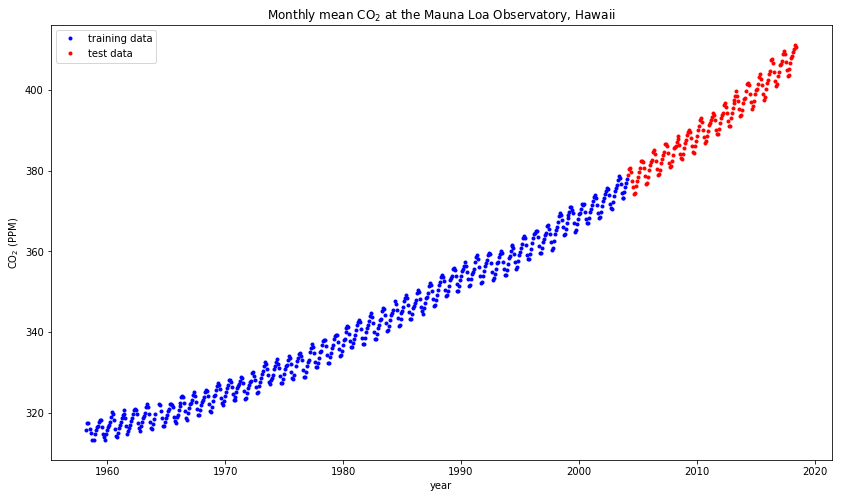

In [30]:
X, Y = data['X'], data['Y']

Xtest, Ytest = data['Xtest'], data['Ytest']

plt.figure(figsize=(14, 8))
plt.plot(X, Y, "b.", Xtest, Ytest, "r.")
plt.legend(labels=["training data", "test data"])
plt.xlabel("year"), plt.ylabel("CO$_2$ (PPM)"), plt.title("Monthly mean CO$_2$ at the Mauna Loa Observatory, Hawaii");

In [31]:
k = GPy.kern.RBF(1, name="rbf")

m = GPy.models.GPRegression(X, Y, k)
m.optimize()

m

GP_regression.,value,constraints,priors
rbf.variance,4586.110653297788,+ve,
rbf.lengthscale,69.57445147306964,+ve,
Gaussian_noise.variance,4.535511421141832,+ve,


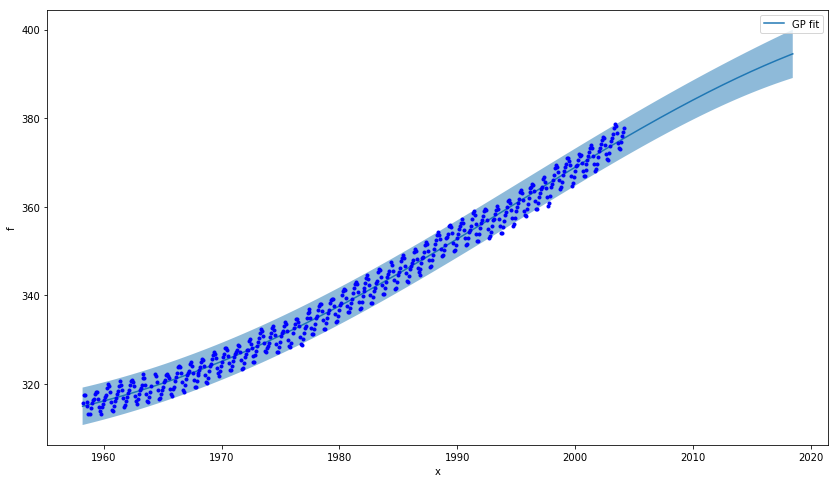

In [32]:
Xnew = np.vstack([X, Xtest])

mean, Cov = m.predict(Xnew, full_cov=True)

plt.figure(figsize=(14, 8))
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, "b.");

It is possible to make the model fit the data near perfectly by minimising the variance of the Gaussian noise in the likelihood.

In [33]:
m.Gaussian_noise.variance = 0.00001
m.Gaussian_noise.variance.fix()
m.optimize()
m

GP_regression.,value,constraints,priors
rbf.variance,51467.99386706932,+ve,
rbf.lengthscale,0.7155192343026379,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


**But** this has no predictive power, and we have really just overfitted to the training data

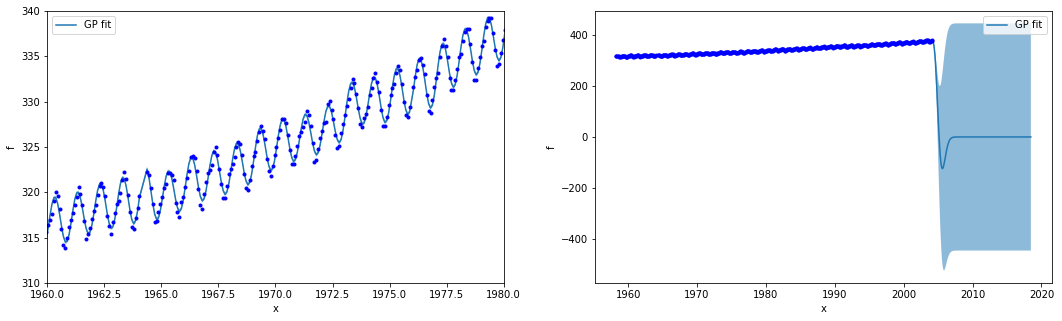

In [34]:
mean, Cov = m.predict(Xnew, full_cov=True)

plt.figure(figsize=(18, 5))

plt.subplot(121)
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, "b.");
plt.gca().set_xlim([1960,1980]), plt.gca().set_ylim([310, 340])

plt.subplot(122)
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, "b.");

### GP Regression with combined covariance functions

Taking a look at the training data, we can see a number of features that occur in the data. There is a clear periodic trend that is yearly, and an approximately linear trend. We can use this prior information in our choice of kernel to give some meaning to the GP fit.

First, we will look at the linear trend. It should be obvious that the overall trend (ignoring the periodicity) can be described approxiximately by $f(x) \approx a + bx$. To embed this as a covariance function, we can use the `Bias` and `Linear` covariance functions, which add a constant and linear trend respectively.

### Exercise 6

(a) Create `Bias` and `Linear` kernels with reasonable estimates of the parameters that represent the trend?

In [35]:
# [answers]
k_B = GPy.kern.Bias(1, variance=1645)
k_L = GPy.kern.Linear(1, variances=[1.])

(b) Create a GP regression model using the kernels to fit the data. Comment on good is the fit and the predictive power of the model? 

GP_regression.,value,constraints,priors
sum.bias.variance,1645.0,+ve,
sum.linear.variances,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


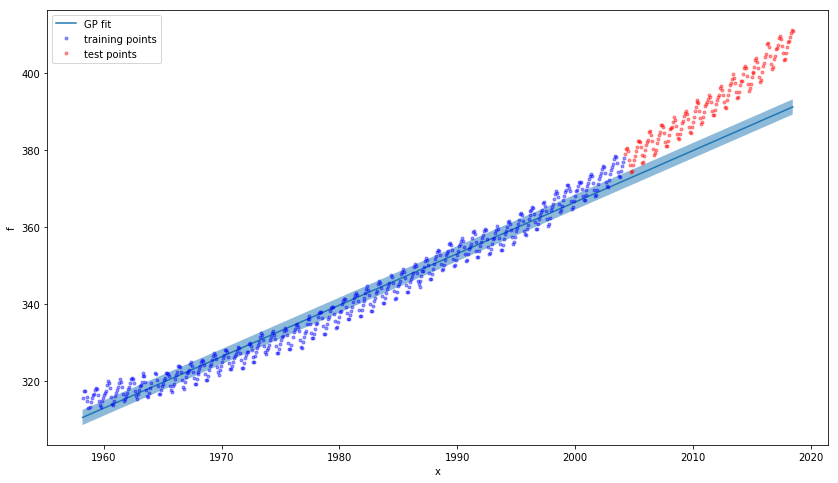

In [36]:
# [answers]
m = GPy.models.GPRegression(X, Y, k_B + k_L)

mean, Cov = m.predict(Xnew)

plt.figure(figsize=(14,8))
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, ".b", Xtest, Ytest, ".r", alpha=0.4);
plt.legend(labels=["GP fit","training points", "test points"])

m

### Periodicity

It's there is a seasonal trend over the year, and that a simple linear fit cannot capture this information. However, we can add this using our choice of kernel by adding a `StdPeriodic` kernel to our regression model. It's evident to the data that the period is yearly, so a period of $\omega=1$ is a sensible choice for our initial parameter:

GP_regression.,value,constraints,priors
sum.bias.variance,10763.39132114431,+ve,
sum.linear.variances,7122.08988616725,+ve,
sum.std_periodic.variance,87730.62687243958,+ve,
sum.std_periodic.period,0.9992602867983462,+ve,
sum.std_periodic.lengthscale,392.1426732930588,+ve,
Gaussian_noise.variance,4.418880258006768,+ve,


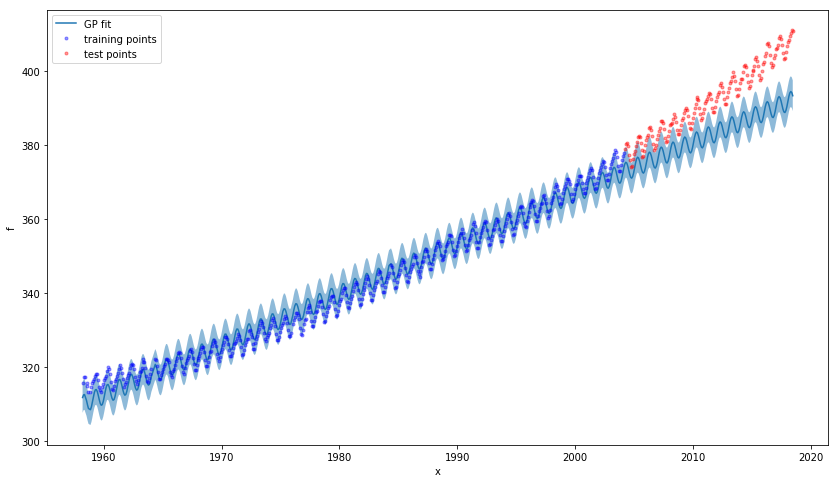

In [37]:
ks = [ # Our kernels
    GPy.kern.Bias(1, variance=10000.),    # Constant offset
    GPy.kern.Linear(1),                   # Linear trend
    GPy.kern.StdPeriodic(1, period=1.)    # Periodicity
]

m = GPy.models.GPRegression(X, Y, ks[0] + ks[1] + ks[2])

m.optimize()

mean, Cov = m.predict(Xnew)

plt.figure(figsize=(14,8))
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, ".b", Xtest, Ytest, ".r", alpha=0.4);
plt.legend(labels=["GP fit","training points", "test points"])

m

From the plot we can see that while we have maintained the periodicity in our prediction, there is some deviation in the amplitude of each period. Likewise, the data is not strictly linear. We can embed model these non-linearities and deviations by adding an `Exponential` kernel. First, in the summative kernel, but also by multiplying a Gaussian RBF by the periodic kernel. For some intiution on how this allows for deviation of the periodicity, see the corresponding sample plot in Section 4.

In [38]:
ks = [ # Our kernels
    GPy.kern.Exponential(1),              # Non-linearity in overall trend
    GPy.kern.Bias(1, variance=10000.),    # Constant offset
    GPy.kern.Linear(1),                   # Linear trend
    GPy.kern.StdPeriodic(1, period=1.),   # Periodicity (short term trend)
    GPy.kern.RBF(1)                       # Amplitude modulator (long term trend)
]

k = ks[0] + ks[1] + ks[2] + ks[3]*ks[4]
k

sum.,value,constraints,priors
Exponential.variance,1.0,+ve,
Exponential.lengthscale,1.0,+ve,
bias.variance,10000.0,+ve,
linear.variances,1.0,+ve,
mul.std_periodic.variance,1.0,+ve,
mul.std_periodic.period,1.0,+ve,
mul.std_periodic.lengthscale,1.0,+ve,
mul.rbf.variance,1.0,+ve,
mul.rbf.lengthscale,1.0,+ve,


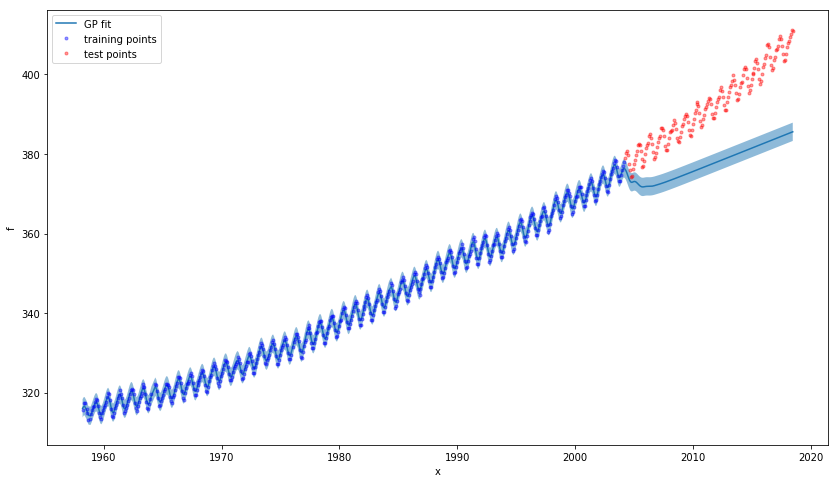

In [39]:
m = GPy.models.GPRegression(X, Y, k)

mean, Cov = m.predict(Xnew)

plt.figure(figsize=(14,8))
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, ".b", Xtest, Ytest, ".r", alpha=0.4);
plt.legend(labels=["GP fit","training points", "test points"]);

Optimization restart 1/5, f = 182.27144498906222
Optimization restart 2/5, f = 566.5750443661341
Optimization restart 3/5, f = 228.626108033305
Optimization restart 4/5, f = 566.4153089824599
Optimization restart 5/5, f = 868.8538856701862


GP_regression.,value,constraints,priors
sum.Exponential.variance,19.972867238944865,+ve,
sum.Exponential.lengthscale,34.356153360048374,+ve,
sum.bias.variance,10000.03362367125,+ve,
sum.linear.variances,0.8253535764584062,+ve,
sum.mul.std_periodic.variance,99.71959664658804,+ve,
sum.mul.std_periodic.period,0.999539830655284,+ve,
sum.mul.std_periodic.lengthscale,3.6405675234125914,+ve,
sum.mul.rbf.variance,99.71959664657379,+ve,
sum.mul.rbf.lengthscale,160.16125073086434,+ve,
Gaussian_noise.variance,9.655458727122856e-84,+ve,


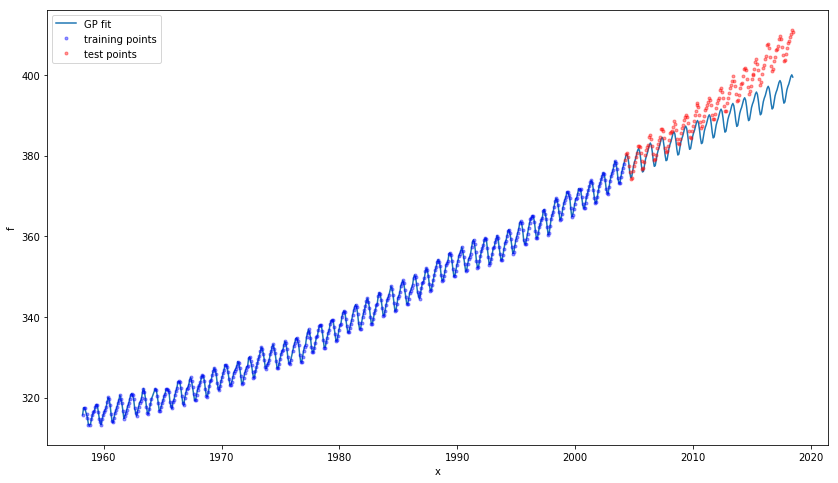

In [40]:
m.optimize_restarts(5, robust=True)

mean, Cov = m.predict(Xnew)

plt.figure(figsize=(14,8))
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, ".b", Xtest, Ytest, ".r", alpha=0.4);
plt.legend(labels=["GP fit","training points", "test points"])

m

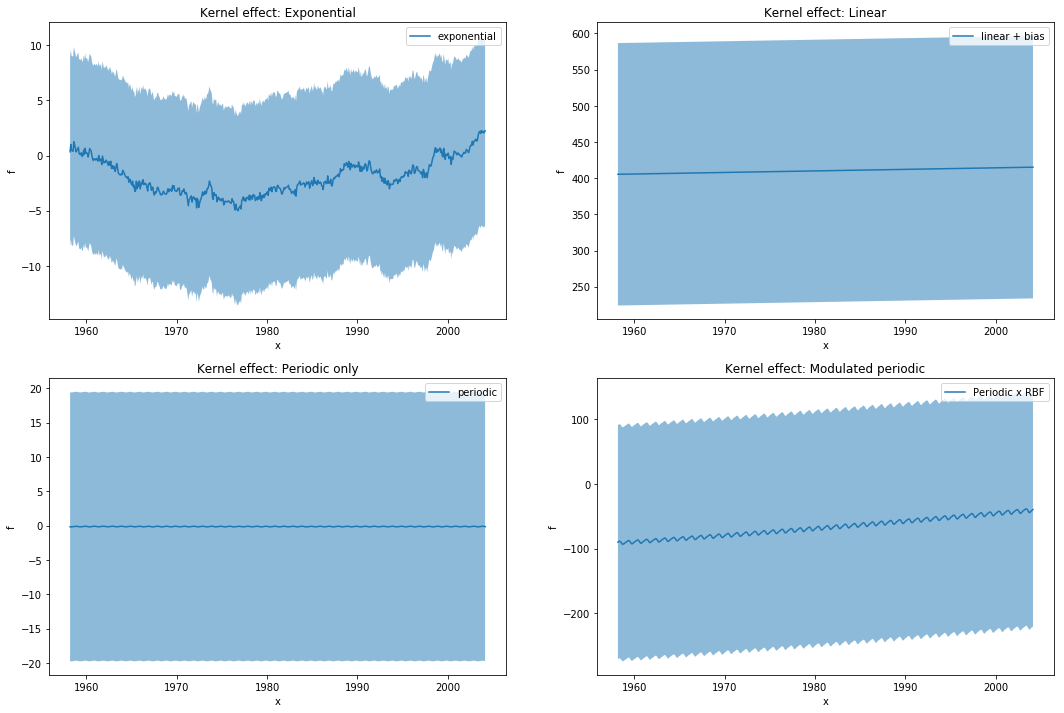

In [41]:
plt.figure(figsize=(18,12))

plt.subplot(221)
mean, Cov = m.predict_noiseless(X, kern=m.sum.Exponential)
plot_gp(X, mean, Cov)
plt.title("Kernel effect: Exponential"), plt.legend(labels=["exponential"])

plt.subplot(222)
mean, Cov = m.predict_noiseless(X, kern=m.sum.linear+m.sum.bias)
plot_gp(X, mean, Cov)
plt.title("Kernel effect: Linear"), plt.legend(labels=["linear + bias"])

plt.subplot(223)
mean, Cov = m.predict_noiseless(X, kern=m.sum.mul.std_periodic)
plot_gp(X, mean, Cov)
plt.title("Kernel effect: Periodic only"), plt.legend(labels=["periodic"])

plt.subplot(224)
mean, Cov = m.predict_noiseless(X, kern=m.sum.mul)
plot_gp(X, mean, Cov)
plt.title("Kernel effect: Modulated periodic"), plt.legend(labels=["Periodic x RBF"]);

### Exercise 7

What other combinations of kernels and parameters could be used to get a better fit, especially for the predictive fit?

## 7. Multiple Inputs

Typically, we will want have data that is more than one-dimensional. Gaussian processes regression is scalable in dimension, and everything used above can be used with multiple inputs.

Consider the toy example

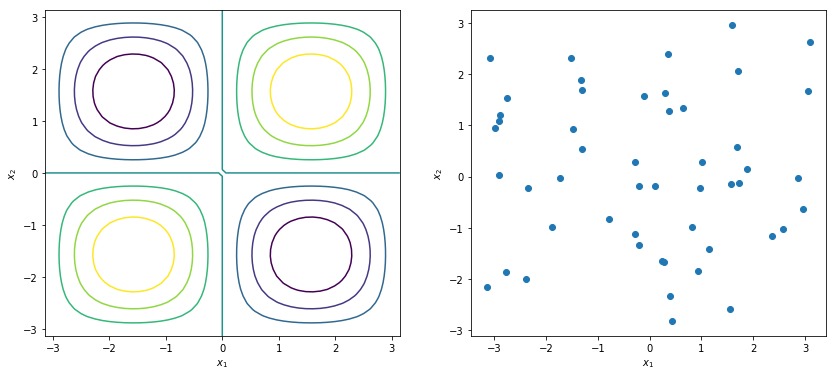

In [42]:
[Xi, Xj] = np.meshgrid(np.linspace(-np.pi, np.pi, 50), np.linspace(-np.pi, np.pi, 50))

f = lambda xi,xj: np.sin(xi) * np.sin(xj)

num_measurements = 50

X2 = np.random.uniform(-np.pi, np.pi, (num_measurements, 2))

plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.contour(Xi, Xj, f(Xi,Xj))
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")

plt.subplot(122)
plt.plot(X2[:,0],X2[:,1],'o')
plt.xlabel("$x_1$"), plt.ylabel("$x_2$");

In [43]:
Y2 = np.array([f(x1,x2) for (x1,x2) in zip(X2[:,0], X2[:,1])])[:,None] + 0.05 * np.random.randn(X2.shape[0], 1)

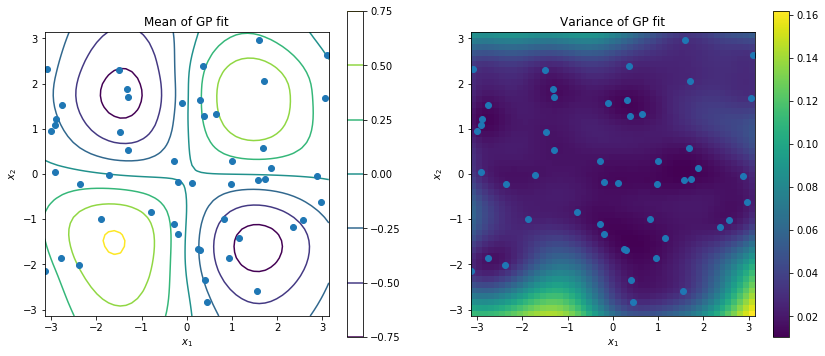

In [44]:
k = GPy.kern.RBF(1, active_dims=[0]) * GPy.kern.Matern32(1, active_dims=[1])

m = GPy.models.GPRegression(X2, Y2, k)

m.Gaussian_noise.variance = 0.05 
m.Gaussian_noise.variance.fix()

m.optimize()

Xnew2 = np.vstack((Xi.ravel(), Xj.ravel())).T # Change our input grid to list of coordinates

mean2, Cov2 = m.predict_noiseless(Xnew2, full_cov=False)

plt.figure(figsize=(14, 6))

plt.subplot(121)          
plt.contour(Xi, Xj, mean2.reshape(Xi.shape))
plt.plot(X2[:,0],X2[:,1],'o'), plt.axis("square")
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Mean of GP fit"), plt.colorbar()
           
plt.subplot(122)          
plt.pcolor(Xi, Xj, Cov2.reshape(Xi.shape))
plt.plot(X2[:,0],X2[:,1],'o'), plt.axis("square")
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Variance of GP fit"), plt.colorbar();

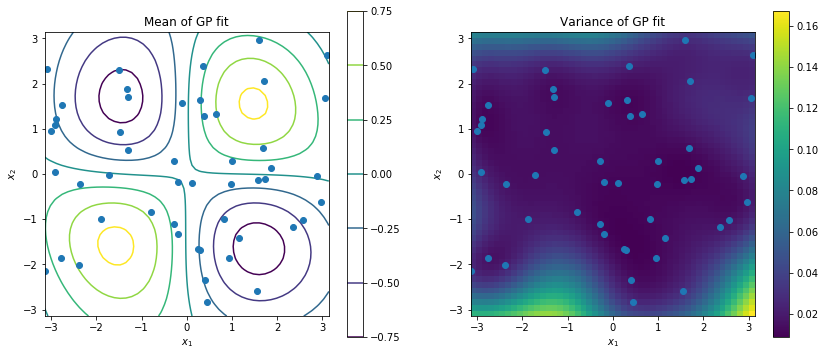

In [45]:
k = GPy.kern.RBF(2, active_dims=[0,1])

m = GPy.models.GPRegression(X2, Y2, k)

m.Gaussian_noise.variance = 0.05 
m.Gaussian_noise.variance.fix()

m.optimize()

Xnew2 = np.vstack((Xi.ravel(), Xj.ravel())).T # Change our input grid to list of coordinates

mean2, Cov2 = m.predict_noiseless(Xnew2, full_cov=False)

plt.figure(figsize=(14, 6))

plt.subplot(121)          
plt.contour(Xi, Xj, mean2.reshape(Xi.shape))
plt.plot(X2[:,0],X2[:,1],'o'), plt.axis("square")
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Mean of GP fit"), plt.colorbar()
           
plt.subplot(122)          
plt.pcolor(Xi, Xj, Cov2.reshape(Xi.shape))
plt.plot(X2[:,0],X2[:,1],'o'), plt.axis("square")
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Variance of GP fit"), plt.colorbar();